# Workflow
1. Define Problem
2. Load Data
3. Data Cleaning / EDA
4. ML Model (KNN)

## 1. Define Problem
> Predict the pitch_name based on release_speed, release_pos_x, release_pos_z, release_spin_rate, (optional: balls and strikes)

In [17]:
# data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine Learning
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier

## 2. Load Data

In [2]:
df = pd.read_csv("statcast_2017.csv")

pitch_name     
4-Seam Fastball    0.347745
Slider             0.162316
2-Seam Fastball    0.129517
Changeup           0.099332
Sinker             0.078767
Curveball          0.078671
Cutter             0.053005
Knuckle Curve      0.029668
Split-Finger       0.016476
Knuckleball        0.003685
Forkball           0.000344
Eephus             0.000258
Pitch Out          0.000162
Screwball          0.000054
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

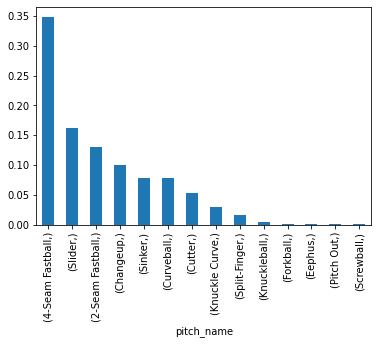

In [3]:
print(df[['pitch_name']].value_counts(normalize= True))
df[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')

From above we can see 14 types of pitch. For more accurate result, we drop 5 infrequent types, Knuckleball, Forkball, Eephus, Pitch Out and Screwball

## 3. Data Cleaning / EDA

In [4]:
# drop columns with high null rate (60%)
print(f"shape of df before dropping high null columns {df.shape}")
df = df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)
print(f"shape of df after dropping high null columns {df.shape}")

# get rid of all null rows
print(f"size before droping null values {df.shape}")
df = df.dropna()
print(f"size after droping null values {df.shape}")

shape of df before dropping high null columns (721244, 93)
shape of df after dropping high null columns (721244, 67)
size before droping null values (721244, 67)
size after droping null values (701248, 67)


In [5]:
# get rid of Knuckleball, Forkball, Eephus, Pitch Out and Screwball
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]
    
values = ['Knuckleball','Forkball','Eephus','Pitch Out','Screwball']
print(f'size before removing row {df.shape}')
df = filter_rows_by_values(df,'pitch_name', values)
print(f'size after removing row {df.shape}')

size before removing row (701248, 67)
size after removing row (700635, 67)


In [6]:
# choose the columns that we chose earlier in the meeting
df_pca = df[['pitch_name','release_speed', 'release_pos_x', 'release_pos_z', 'release_spin_rate']]

In [7]:
# drop all the null values before running PCA
print(f"size before droping null values {df_pca.shape}")
df_pca = df_pca.dropna()
print(f"size after droping null values {df_pca.shape}")

size before droping null values (700635, 5)
size after droping null values (700635, 5)


In [8]:
# Choose 1,000 samples and run PCA to see whether there are clusters
df_pca = df_pca.sample(n=1000, random_state=1)
df_pca_X = df_pca.drop('pitch_name',axis = 1)

pca = PCA(n_components=2)
components = pca.fit_transform(df_pca_X)

Text(0, 0.5, 'cumulative explained variance')

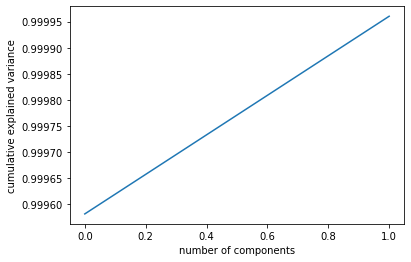

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [10]:
components[:,0]
fig = px.scatter(components, x=components[:,0], y=components[:,1], color = df_pca.pitch_name, hover_name = df_pca.pitch_name)
fig.show()

In this section let's try to use ANOVA feature selection for numeric input and categorical output. In other words, let's try to choose numerical columns that correlates with our target variables

In [11]:
# Choose X
X = df.select_dtypes(include=np.number)
print(X.columns)
X.head()
# X.drop(['Unnamed: 0','batter', 'pitcher'], axis = 1)

Index(['Unnamed: 0', 'release_speed', 'release_pos_x', 'release_pos_z',
       'batter', 'pitcher', 'zone', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'outs_when_up', 'inning', 'fielder_2',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk',
       'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5',
       'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'at_bat_number', 'pitch_number', 'home_score', 'away_score',
       'bat_score', 'fld_score', 'post_away_score', 'post_home_score',
       'post_bat_score', 'post_fld_score', 'spin_axis', 'delta_home_win_exp',
       'delta_run_exp'],
      dtype='object')


,Unnamed: 0,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,balls,strikes,game_year,...,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp
0,2265,91.9,-1.19,5.99,595885,532077,1.0,3,2,2017,...,2,1,2,2,1,1,2,183.0,-0.044,-0.124
1,2350,91.8,-1.08,6.18,595885,532077,3.0,3,1,2017,...,2,1,2,2,1,1,2,164.0,-0.044,-0.035
2,2397,94.7,-0.62,6.34,595885,532077,12.0,2,1,2017,...,2,1,2,2,1,1,2,189.0,-0.044,0.038
3,2485,82.8,-0.99,6.06,595885,532077,13.0,1,1,2017,...,2,1,2,2,1,1,2,226.0,-0.044,0.020
4,2666,95.9,-0.89,6.13,595885,532077,13.0,0,1,2017,...,2,1,2,2,1,1,2,221.0,-0.044,0.014


Let's drop unnecessary columns, Unnamed: 0, batter, pitcher, 

In [12]:
X = X.drop(['Unnamed: 0','batter', 'pitcher'], axis = 1)
X

,release_speed,release_pos_x,release_pos_z,zone,balls,strikes,game_year,pfx_x,pfx_z,plate_x,...,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp
0,91.9,-1.19,5.99,1.0,3,2,2017,-0.06,1.54,-0.48,...,2,1,2,2,1,1,2,183.0,-0.044,-0.124
1,91.8,-1.08,6.18,3.0,3,1,2017,0.31,1.17,0.55,...,2,1,2,2,1,1,2,164.0,-0.044,-0.035
2,94.7,-0.62,6.34,12.0,2,1,2017,-0.27,1.84,1.54,...,2,1,2,2,1,1,2,189.0,-0.044,0.038
3,82.8,-0.99,6.06,13.0,1,1,2017,-1.27,1.38,-0.21,...,2,1,2,2,1,1,2,226.0,-0.044,0.020
4,95.9,-0.89,6.13,13.0,0,1,2017,-1.19,1.50,-0.79,...,2,1,2,2,1,1,2,221.0,-0.044,0.014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721239,98.4,-1.23,5.15,9.0,0,0,2017,-1.28,0.68,0.42,...,0,0,0,0,0,0,0,246.0,0.000,-0.060
721240,84.6,-1.25,5.39,8.0,2,1,2017,1.10,-0.17,0.14,...,0,0,0,0,0,0,0,74.0,-0.036,0.346
721241,97.3,-1.32,5.18,13.0,1,1,2017,-1.34,0.55,-0.01,...,0,0,0,0,0,0,0,252.0,0.000,0.050
721242,95.9,-1.31,5.48,7.0,1,0,2017,-1.59,0.84,-0.58,...,0,0,0,0,0,0,0,245.0,0.000,-0.046


In [22]:
# Create and fit selector
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X, df.pitch_name)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_new = X.iloc[:,cols]
X_new.shape

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [6] are constant.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide



(700635, 15)

The above result shows the 15 best columns to choose to make a classification model

## 4. ML Model (KNN)

In [23]:
from sklearn.preprocessing import MinMaxScaler
data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
scaler = MinMaxScaler()
print(scaler.fit(X_new))
print(scaler.transform(X_new))


MinMaxScaler()
[[0.79187817 0.69675926 0.57768362 ... 0.11564626 0.8845761  0.50833333]
 [0.79018613 0.71875    0.6299435  ... 0.11904762 0.88219271 0.45555556]
 [0.8392555  0.73726852 0.5480226  ... 0.12244898 0.87810691 0.525     ]
 ...
 [0.88324873 0.60300926 0.39689266 ... 0.10544218 0.8927477  0.7       ]
 [0.85956007 0.63773148 0.36158192 ... 0.10204082 0.90194076 0.68055556]
 [0.84263959 0.65046296 0.4759887  ... 0.10204082 0.90194076 0.60555556]]


In [24]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_new, df.pitch_name)
#https://realpython.com/knn-python/

KNeighborsClassifier()